In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import system as sys
import profile_maker
import wb_writer

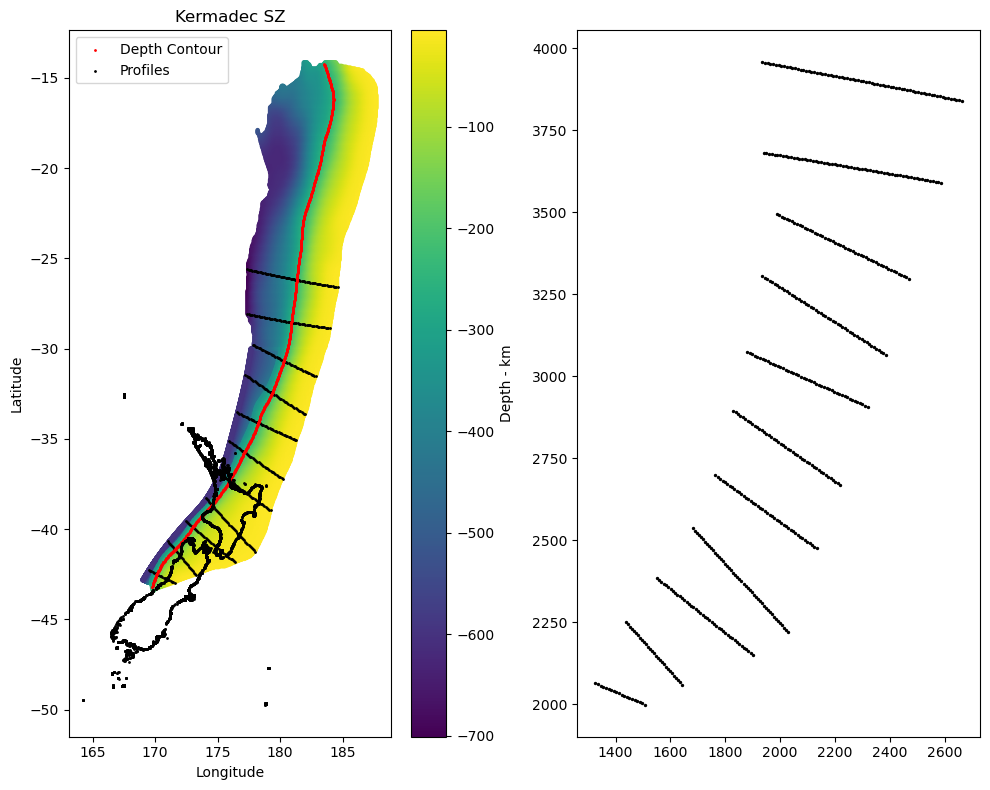

In [13]:
# Load the slab2.0 data and the coastline of New Zealand
coast_arr = np.loadtxt(fname="data/coastline.txt")
slab2_cont = np.loadtxt(fname='data/slab2_tonga.in', delimiter='\t', comments='>', dtype=float)
slab2_dep = np.loadtxt(fname='data/combined_slab2.txt')

# Specify parameters for profile generation
depth_contour = -260
prof_num = 10
profile_spacing = 3
lon_spacing = 0.1
lat_spacing = 0.1
max_distance_point = 10
region_lon = [170, 190]
region_lat = [-42.5, -26]
output_dir = 'profile_output'
use_trench = False

# Write the profiles
# profile_maker.profile_generator(slab2_dep, slab2_cont, output_dir, depth_contour, prof_num, profile_spacing, region_lon, region_lat, \
#                                 lon_spacing, lat_spacing, max_distance_point, 90, 'East', use_trench)

# Plot data with Profiles
plt.figure(dpi=100, figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Kermadec SZ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(slab2_dep[:,0], slab2_dep[:,1], c=slab2_dep[:,2], s = 5)
plt.colorbar(label = 'Depth - km')
for file in np.sort(os.listdir(output_dir + '/geographic')):
    profile_file = np.loadtxt(fname=output_dir + '/geographic/' + file)
    plt.scatter(profile_file[:, 0], profile_file[:, 1], c = 'k', s=1)
plt.scatter(slab2_cont[np.where(slab2_cont[:, 2] == depth_contour)][:, 0], slab2_cont[np.where(slab2_cont[:, 2] == depth_contour)][:, 1], s = 1, c='r', label='Depth Contour')
plt.scatter(coast_arr[:, 0], coast_arr[:, 1], s = 1, c='k', label = 'Profiles')
plt.legend()

# Plot the projected Cartesian profiles
plt.subplot(1, 2, 2)
for file in np.sort(os.listdir(output_dir + '/cartesian')):
    profile_file = np.loadtxt(fname=output_dir + '/cartesian/' + file)
    plt.scatter(profile_file[:, 0] + 2200, profile_file[:, 1] + 3000, c = 'k', s = 2)
    
plt.tight_layout()

# Create the WorldBuilder File

In [16]:
# Specify bounds and coordinates of the desired World
x_bounds = [0, 4000e3]
y_bounds = [0, 4000e3]
coordinates = [[np.min(x_bounds), np.min(y_bounds)], [np.min(x_bounds), np.max(y_bounds)], \
               [np.max(x_bounds), np.max(y_bounds)], [np.max(x_bounds), np.min(y_bounds)]]

# Extract the location of the trench (needed for specifying section coordinates when making the slab)
profile_directory = 'profile_output/cartesian/'
xshift = 2000 # m
yshift = 2000 # m
trench_x, trench_y = wb_writer.trench_extractor(profile_directory, xshift, yshift, 'East', 'Cartesian')

trench_coordinates =  []
for i in range(len(trench_x)):
    trench_coordinates.append( [trench_x[i], trench_y[i]] )

# Create two arrays which defines the bounds for the unsubducted oceanic lithosphere, and the overriding
# continental lithosphere
oceanic_plate_coords, continental_plate_coords = wb_writer.trench_splitter(trench_x, trench_y, x_bounds, y_bounds, 'East')


# Remove worldbuilder file if the file already exists for a clean new file, then create the .wb file
sys('rm 3D_Hikurangi_slab.wb')
world_builder_file = open('3D_Hikurangi_slab.wb', 'a+')

# Write the header of the .wb file
world_builder_file.write('{\n')
world_builder_file.write('  "version":"0.6",\n')
world_builder_file.write('  "features":\n')
world_builder_file.write('  [\n\n')

###################################################################################################################################################

# First create a mantle layer. This has to be done first because WorldBuilder will override old layers with new
# layers (unless specified), and we want the slab to overwrite the mantle layer.
model_name = 'mantle layer'
feature_name = 'Mantle'
min_depth = 125e3 # m
max_depth = 2891e3 # m

temp_model = 'linear'
temp_min = 125e3 # m
temp_max = 2891e3 # m
top_temp = 1600 # K
bottom_temp = 3000 # K

composition_model = 'uniform'
composition_0 = 0
max_depth_0 = 2891e3 # m
min_depth_0 = 125e3 # m

# Here we write the strings for the mantle layer
world_builder_file.write('{\n') # This defines a new feature
world_builder_file.write(wb_writer.model_feature_string(model_name, feature_name, min_depth, max_depth, coordinates, is_subducting=False, dip_point=0))
world_builder_file.write(wb_writer.linear_model(temp_model, temp_max, temp_min, bottom_temp, top_temp, first_or_last='both'))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_0, max_depth_0, min_depth_0, is_subducting=False, first_or_last='both'))
world_builder_file.write('},\n\n') # This closes the feature

###################################################################################################################################################

# Create an overriding plate feature using the continental_plate_coords output from trench_splitter()
model_name = 'continental plate'
feature_name = 'Overriding Continental Lithosphere'
min_depth = 0 # m
max_depth = 125e3 # m

temp_model = 'linear'
temp_max = 125e3 # m
temp_min = 0.0 # m
bottom_temp = 1600 # K
top_temp = 300 # K

composition_model = 'uniform'
composition_1 = 1
max_depth_1 = 125e3 # m
min_depth_1 = 0 # m

world_builder_file.write('{\n') # This defines a new feature
world_builder_file.write(wb_writer.model_feature_string(model_name, feature_name, min_depth, max_depth, continental_plate_coords, is_subducting=False, dip_point=0))
world_builder_file.write(wb_writer.linear_model(temp_model, temp_max, temp_min, bottom_temp, top_temp, first_or_last='both'))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_1, max_depth_1, min_depth_1, is_subducting=False, first_or_last='both'))
world_builder_file.write('},\n\n') # This closes the feature

###################################################################################################################################################

# Create an unsubducted oceanic plate feature using the oceanic_plate_coords output from trench_splitter()
model_name = 'oceanic plate'
feature_name = 'Unsubducted Oceanic Lithosphere'
min_depth = 0.0 # m
max_depth = 125e3 # m

temp_model = 'half space model'
temp_max = 125e3 # m
temp_min = 0.0 # m
top_temp = 300 # K
bottom_temp = 1600 # K
spr_vel = 0.005 # m/yr
ridge_coords = [[[4001e3, 0.0], [4001e3, 4000e3]]] # m

composition_model = 'uniform'
composition_2 = 2
max_depth_2 = 125e3 # m
min_depth_2 = 0 # m

world_builder_file.write('{\n') # This defines a new feature
world_builder_file.write(wb_writer.model_feature_string(model_name, feature_name, min_depth, max_depth, oceanic_plate_coords, is_subducting=False, dip_point=0))
world_builder_file.write(wb_writer.cooling_model(temp_model, temp_max, temp_min, bottom_temp, top_temp, spr_vel, ridge_coords, first_or_last='both'))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_2, max_depth_2, min_depth_2, is_subducting=False, first_or_last='both'))
world_builder_file.write('},\n\n') # This closes the feature

###################################################################################################################################################

# Create the subducting plate feature connected to the unsubducted oceanic plate feature written above. Uses the trench_coordinates
# output by trench_extractor() to define the locations of the sections, and then iterates through all profiles to define the segments
# in each section.
feature_name = 'Subducting Oceanic Lithosphere'
model_name = 'subducting plate'
min_depth = 0 # m
max_depth = 100000e3 # m
coordinate_system = 'Cartesian'

# Parameters for the Mass Convserving Temperature Model (Unique to subducting slabs)
dip_point = [-2000e8, 2000e3] # m
density = 3300 # kg/m3
plate_vel = 0.005 # m/yr
couple_depth = 125e3 # m
taper = 0 # m
max_slab_top = 250e3 # m
min_slab_top = -250e3 # m
segment_thickness = 125e3 # m
top_truncation = [-125e3] # m

composition_model = 'uniform'
composition_2 = 2
max_depth_2 = 100000e3 # m
min_depth_2 = 0 # m

world_builder_file.write('{\n') # This defines a new feature
world_builder_file.write(wb_writer.model_feature_string(model_name, feature_name, min_depth, max_depth, trench_coordinates, is_subducting=True, dip_point=dip_point))
wb_writer.segment_section(world_builder_file, profile_directory, xshift, yshift, segment_thickness, top_truncation, coordinate_system)
world_builder_file.write('    ],\n') # This closes the list of sections

world_builder_file.write(wb_writer.mass_conserving_model(density, plate_vel, couple_depth, ridge_coords, taper, max_slab_top, min_slab_top, first_or_last='both'))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_2, max_depth_2, min_depth_2, is_subducting=True, first_or_last='both'))
world_builder_file.write('}\n\n') # This closes the feature (no , since it is the LAST feature)

###################################################################################################################################################

# Finally, close out the worldbuilder file
world_builder_file.write('')
world_builder_file.write(']\n')
world_builder_file.write('}')
world_builder_file.close()